This is the file system of our sample dataset - training, validation and test pictures.
```
cats_and_dogs
|__ train:
    |______ cats: [cat.0.jpg, cat.1.jpg ...]
    |______ dogs: [dog.0.jpg, dog.1.jpg ...]
|__ validation:
    |______ cats: [cat.2000.jpg, cat.2001.jpg ...]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg ...]
|__ test: [1.jpg, 2.jpg ...]
```

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Downloading our datasets.

In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip -q cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 25
IMG_HEIGHT = 150
IMG_WIDTH = 150

--2022-07-30 22:23:00--  https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 172.67.70.149, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70702765 (67M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  67.43M   166MB/s    in 0.4s    

2022-07-30 22:23:01 (166 MB/s) - ‘cats_and_dogs.zip’ saved [70702765/70702765]



Here we are creating image generators for each of the three image sets. 

In [3]:
rescale=1/255

#Avoid overfitting by creating additional training data through transformations
train_image_generator = ImageDataGenerator(
    rescale=rescale,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    fill_mode="nearest"
)
validation_image_generator = ImageDataGenerator(rescale=rescale)
test_image_generator = ImageDataGenerator(rescale=rescale)

Then we are reading the images and converting them into floating point tensors. We are rescaling the values from 0-255 to 0-1.

In [4]:
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary')

test_data_gen = test_image_generator.flow_from_directory(
    batch_size=batch_size,
    classes=["."],
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


Plotting a single image with 5 of its transformations as a progress check.

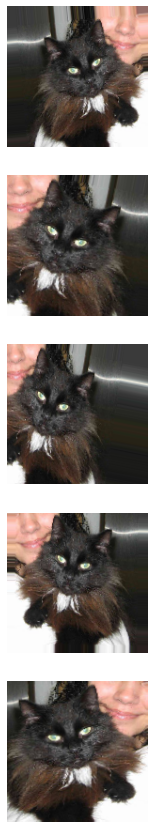

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

We are creating a model with 7 layers: the first one being our input layer with the image dimensions and an RGB channel; 2nd to 6th are hidden and the 7th is our output layer for our 2 classes. As activation function we use ReLu.

The model is compiled with the `Adam` optimizer and `Sparse Categorical Crossentropy` as loss. As metrics we use `accuracy`.

In [6]:
model = Sequential([
    Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name = 'input'),
    Conv2D(16, (5,5), padding='same', activation='relu', name = 'layer2'),
    MaxPooling2D(),
    Conv2D(32, 5, padding='same', activation='relu', name = 'layer3'),
    MaxPooling2D(),
    Conv2D(64, 5, padding='same', activation='relu', name = 'layer4'),
    MaxPooling2D(),
    Conv2D(64, 5, padding='same', activation='relu', name = 'layer5'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu', name = 'layer6'),
    Dense(2, name = 'output')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer2 (Conv2D)             (None, 150, 150, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 layer3 (Conv2D)             (None, 75, 75, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 layer4 (Conv2D)             (None, 37, 37, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

Training of our model with the `fit` function.

In [ ]:
history = model.fit(
    train_data_gen,
    epochs=epochs, 
    validation_data=val_data_gen,
    verbose = 1,
)

Looking at our model's history.

In [ ]:
metrics = ['accuracy','val_accuracy','loss','val_loss']
[acc, val_acc, loss, val_loss] = [history.history[metric] for metric in metrics]

epochs_range = range(epochs)

Visualizing our model accuracy and loss.

In [ ]:
color = 'red'
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color = color)
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss', color = color)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predicting on our test dataset.

In [ ]:
predicted = model.predict(test_data_gen).tolist()

def fun(x):
  if x[0] < x[1]:
    return 1
  else:
    return 0

probabilities = map(lambda x: fun(x), predicted)

Seeing the actual accuracy of our model by comparing with answers for the test images.

In [ ]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if probability == answer:
    correct +=1

percentage_identified = (correct / len(answers))
percentage_identified = round(percentage_identified, 2)*100

print(f"Actual accuracy rate on test set: {percentage_identified}%")

In [ ]:
fig = plt.figure(figsize=(6, 6))
axis = plt.add_axes([0,0,1,1])
x_labels = ['Expected', 'Actual']
y_values = [percentage_identified, acc[-1]]
axis.bar(x_labels,y_values)
plt.title("Accuracy")
plt.show()
